In [1]:
#!/usr/bin/env python
# coding: utf-8


import torch
import json
import ast
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import cv2

import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, AutoModelForObjectDetection, AutoImageProcessor, pipeline
from datasets import load_dataset
import os
import requests


2024-12-10 04:14:19.049093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 04:14:19.049163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 04:14:19.050970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 04:14:19.062247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# download a sample image
# ! streaming mode only gives IterableDataset (also takes some while to obtain photo)
# ! no indexing, can only iterate via for loop
yalu_ds_list = ["SeaSponge/wildme_dataset", "SeaSponge/wildme10_classify", "yin30lei/wildlife_very_dark"] 
yalu_ds = yalu_ds_list[2]
wildlife_ds = load_dataset(yalu_ds, cache_dir=Path.cwd() / "yalu_dataset", streaming=True)



print(wildlife_ds["train"])
# print(wildlife_ds["validation"])
print(wildlife_ds["test"])

train_ds = wildlife_ds["train"]
# val_ds = wildlife_ds["validation"]
test_ds = wildlife_ds["test"]



del wildlife_ds

try:
    # object of type 'IterableDataset' has no len()
    
    # Subclasses of Dataset should implement __getitem__.
    for idx, sample in enumerate(train_ds):
        print(f"idx-> {idx} | sample -> {sample}")
        break
    
except Exception as e:
    print(f"error -> {e}")



def get_record(dataset, index):
    for i, record in enumerate(dataset):
        if i == index:
            return record
    raise IndexError("Index out of range")


IterableDataset({
    features: ['file_name', 'image_id', 'width', 'height', 'image', 'labels'],
    n_shards: 10
})
IterableDataset({
    features: ['file_name', 'image_id', 'width', 'height', 'image', 'labels'],
    n_shards: 2
})
idx-> 0 | sample -> {'file_name': '30001419.jpg', 'image_id': 858, 'width': 500, 'height': 344, 'image': <PIL.Image.Image image mode=RGB size=500x344 at 0x7F774A8E52D0>, 'labels': 'fox'}


In [ ]:
# make the object detection pipeline
device = "cuda" if torch.cuda.is_available else "cpu"

hf_path_list = ["SeaSponge/glow-vit", "SeaSponge/glow-vit-dark"]
hf_path = hf_path_list[0]
obj_classifier = pipeline("image-classification", model=hf_path, device=device)
# image = wildlife_ds["train"][0]["image"]

image = get_record(train_ds, 0)["image"]

# Convert to PIL and ensure it's RGB
if not isinstance(image, Image.Image):
    image = Image.fromarray(image)
image = image.convert("RGB") 

print("image")
print(image)
print(obj_classifier)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

image
<PIL.Image.Image image mode=RGB size=500x344 at 0x7F7748754AD0>


In [4]:
# default in dataset is <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2400x1800 at 0x21CF8A7EB90>
results = obj_classifier(image)
# Look something like this:
# [{'label': 'leopard', 'score': 0.9535987377166748}, {'label': 'hyena', 'score': 0.0581585057079792}]
# results for first image -> [{'label': 'lion', 'score': 0.999165415763855}, {'label': 'bear', 'score': 0.347189337015152}, 
# {'label': 'raccoon', 'score': 0.32548221945762634}, {'label': 'wolf', 'score': 0.31772932410240173}, 
# {'label': 'tiger', 'score': 0.3089353144168854}]

print(f"results for first image -> {results}")


results for first image -> [{'label': 'fox', 'score': 0.9957081079483032}, {'label': 'hyena', 'score': 0.7191957831382751}, {'label': 'leopard', 'score': 0.3628193438053131}, {'label': 'tiger', 'score': 0.35832205414772034}, {'label': 'deer', 'score': 0.34843090176582336}]


The expected result -> hare | actual result -> [hyena : 98.38%]


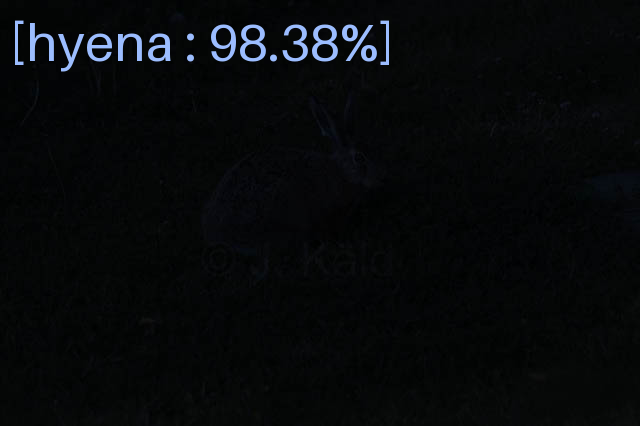

In [5]:
def plot_results(image, results, expect_res=None, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    width, height = image.size
    draw = ImageDraw.Draw(image)
    best_score = 0.0
    best_label = ""
    best_res = f"[{results[0]['label']} : {round(results[0]['score'] * 100), 2}%]"
    for idx, result in enumerate(results):
        label, score = result["label"], result["score"]
        if score > best_score:
            best_score = score
            best_label = label
            best_res = f"[{best_label} : {round(best_score * 100, 2)}%]"
        
    draw.text((10, 10), text=best_res,
              fill=(156, 189, 255, 255) if best_score > threshold else (181, 22, 85, 255),
              font_size=52)
    print(f"The expected result -> {expect_res} | actual result -> {best_res}")
    return image


def predict(image, pipeline, expect_res=None, threshold=0.7, verbose=False):
    results = pipeline(image)
    if verbose:
        print(results)
    return plot_results(image, results, expect_res, threshold)


# Let's test for another test image
iter_temp = iter(test_ds)
sample = next(iter_temp)
img = sample["image"]
expected = sample["labels"]
predict(img, obj_classifier, expect_res=expected, verbose=False)        

In [6]:
def plot_images(dataset, indices, verbose=False):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(dataset[idx]["image"], obj_classifier, verbose=verbose)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()
    
def plot_images_iterable(dataset, indices, verbose=False):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    
    ds_iter = iter(dataset)
    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        sample = next(ds_iter)
        image = predict(sample["image"], obj_classifier, expect_res=sample["labels"], verbose=verbose)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

The expected result -> fox | actual result -> [fox : 99.57%]
The expected result -> fox | actual result -> [hyena : 94.49%]
The expected result -> wolf | actual result -> [fox : 99.82%]
The expected result -> bear | actual result -> [fox : 97.03%]
The expected result -> tiger | actual result -> [fox : 98.46%]


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


The expected result -> bear | actual result -> [fox : 98.65%]
The expected result -> tiger | actual result -> [hyena : 99.2%]
The expected result -> lion | actual result -> [hyena : 99.68%]
The expected result -> bear | actual result -> [fox : 84.77%]
The expected result -> hyena | actual result -> [hyena : 99.76%]
The expected result -> hyena | actual result -> [hyena : 99.75%]
The expected result -> tiger | actual result -> [hyena : 98.94%]


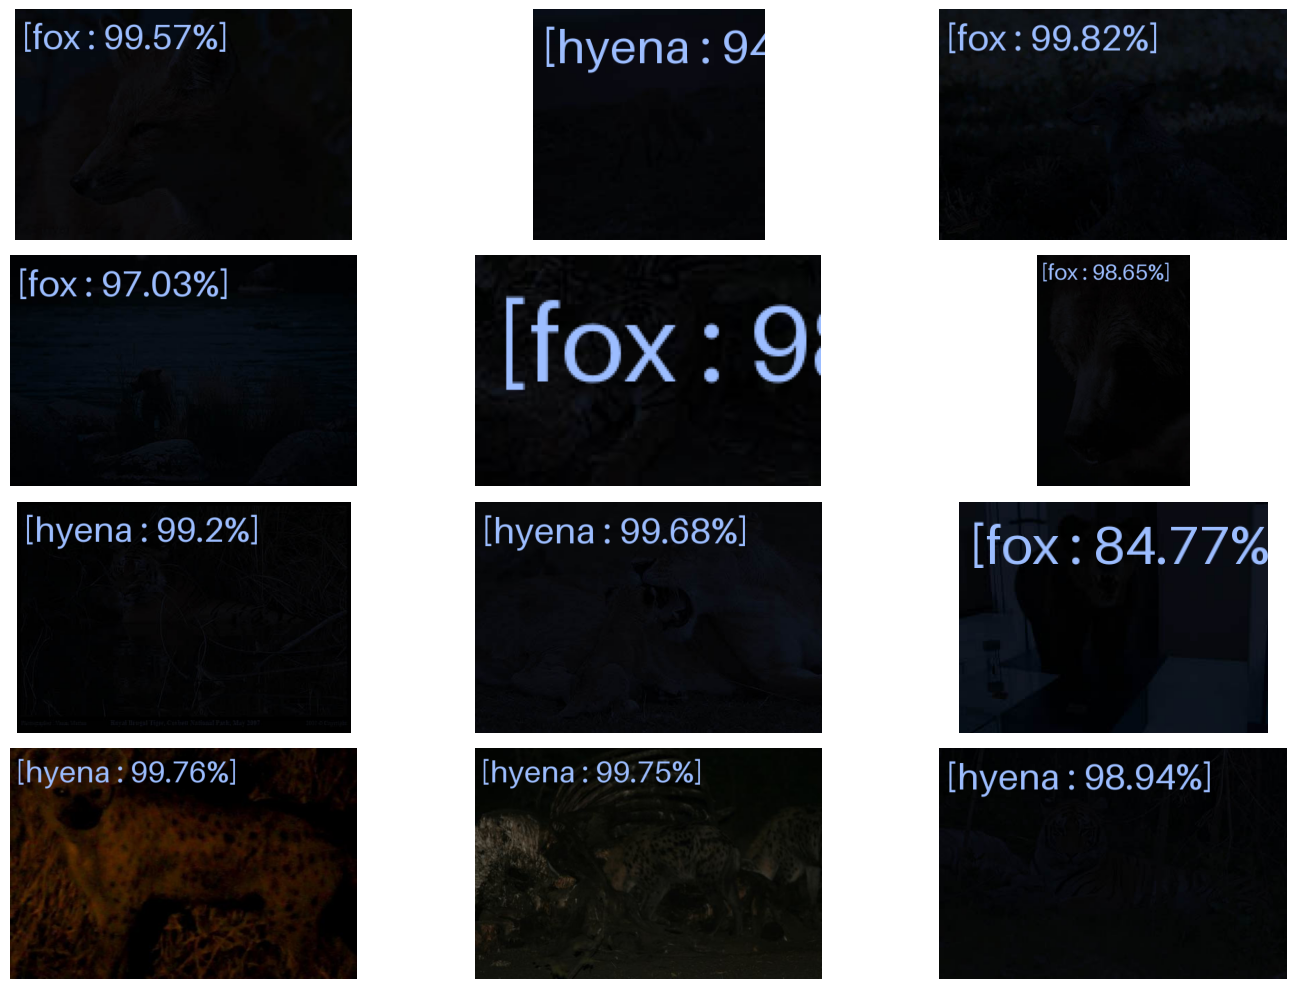

In [7]:
plot_images_iterable(train_ds, range(12), verbose=False)

In [8]:
def load_images_from_folder(folder, batch_size, max_images=None):
    images = []
    filenames = sorted(os.listdir(folder))  # Sort to maintain order
    count = 0  # Keep track of the number of images loaded

    for filename in filenames:
        if max_images and count >= max_images:
            break

        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append((img, filename))
            count += 1

        if len(images) == batch_size:  # Return a batch when size is reached
            yield images
            images = []  # Reset for next batch

    if images:  # Yield remaining images if any
        yield images



def plot_process_folder(folder, batch_size=5, max_images=None, verbose=False):
    """
    Process a folder of images in batches, with an optional limit on the number of images.

    Args:
        folder (str): Path to the folder containing images.
        batch_size (int): Number of images to process in each batch.
        max_images (int, optional): Maximum number of images to load. If None, all images are loaded.
    """
    for batch in load_images_from_folder(folder, batch_size, max_images):
        original_images, filenames = zip(*batch)
        num_rows = batch_size // 3
        num_cols = 3
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

        for i in tqdm(range(batch_size)):
            row = i // num_cols
            col = i % num_cols

            # Draw image

            image = original_images[i]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(image)
            image = image.convert("RGB")
            
            image = predict(image, obj_classifier, verbose=verbose)

            # print(f"axes: {axes}")

            # Display image on the corresponding subplot
            axes[row, col].imshow(image)
            axes[row, col].axis("off")

        plt.tight_layout()
        plt.show()

In [9]:
# max_images_to_process = 9
# folder_path = Path.cwd().resolve().parent / "data/leopard_separated/dark"
# print(folder_path)
# plot_process_folder(folder_path, batch_size=9, max_images=max_images_to_process, verbose=False)  # Adjust batch size as needed